In [2]:
import os
import re
import glob
import json
import random
import jiwer
import argparse
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import subprocess
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import MeCab
import pykakasi
import sentencepiece as spm
# import pyopenjtalk

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
import tensorflow_datasets as tfds

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

from transformers import (
    M2M100Tokenizer,
    Wav2Vec2Config,
    Wav2Vec2ForCTC, 
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor)

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

hira_list = [
    # Gojuon letters
    'あ','い','う','え','お' # a-row
    'か','き','く','け','こ', # ka-row
    'さ','し','す','せ','そ',# sa-row
    'た','ち','つ','て','と', # ta-row
    'な','に','ぬ','ね','の',# na-row
    'は','ふ','へ','ほ','ひ', # ha-row
    'ま','め','も','み','む',# ma-row
    'や','よ','ゆ', # ya-row
    'ら','り','る','れ','ろ', # ra-row
    'わ','を', # wa-row
    'ん', # n-row

    # Dakuon letters
    'が','ぎ','ぐ','げ','ご', # ga-row
    'ざ','ぜ','ず','じ','ぞ', # za-row
    'だ','ど','づ','で','ぢ', # da-row
    'ぼ','び','ぶ','べ','ば', # ba-row

    # Han-Dakuon letters
    'ぱ','ぴ','ぷ','ぺ','ぽ',

    # Yoon letters
    'ょ','ゅ','ゃ',
    'ぇ','ぁ','ぉ','ぃ','っ'] # half-width

In [7]:
with open("Datasets\ASR-dataset/vocab_m2m.json", "r", encoding="utf-8") as f:
    lines = json.load(f)

print(lines)

{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, ',': 4, '.': 5, '▁de': 6, '-': 7, '▁a': 8, ':': 9, '▁...': 10, '▁(': 11, "'": 12, '▁i': 13, '▁la': 14, '▁-': 15, '▁e': 16, ')': 17, '▁na': 18, '’': 19, '▁en': 20, '▁sa': 21, '▁': 22, '▁на': 23, '?': 24, '▁o': 25, '...': 26, '▁que': 27, '▁in': 28, '▁и': 29, '!': 30, '▁d': 31, '▁se': 32, '▁"': 33, '▁da': 34, '▁un': 35, '▁–': 36, '。': 37, '▁l': 38, '▁di': 39, 'in': 40, '▁“': 41, '、': 42, '▁в': 43, 'ar': 44, '▁og': 45, 'as': 46, '▁y': 47, '▁an': 48, 'en': 49, 'es': 50, 'u': 51, '،': 52, 'an': 53, '▁je': 54, 's': 55, 'et': 56, '/': 57, '▁A': 58, 'at': 59, 'is': 60, '▁do': 61, '▁er': 62, 'os': 63, '"': 64, '▁ti': 65, 'y': 66, '▁z': 67, '▁S': 68, '▁v': 69, '▁s': 70, 'al': 71, 'it': 72, '▁за': 73, 'er': 74, 'n': 75, '▁el': 76, '▁u': 77, ';': 78, '▁ka': 79, '的': 80, 'us': 81, 'on': 82, '▁die': 83, '▁و': 84, 'o': 85, '▁le': 86, '▁•': 87, 't': 88, '”': 89, 'a': 90, 'el': 91, '▁B': 92, '▁si': 93, '▁«': 94, 'ak': 95, '▁·': 96, '▁да': 97, '▁L': 98, 'am':

In [2]:
M2M100Tokenizer(vocab_file=r"Datasets\ASR-dataset\vocab.json")

TypeError: __init__() missing 1 required positional argument: 'spm_file'

In [2]:
def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Random seed set.")

def ArgParser():
    parser = argparse.ArgumentParser()

    # DataLoader
    parser.add_argument("--main_dir", default="Datasets\ASR-dataset")
    parser.add_argument("--sample_rate", default=16000)
    parser.add_argument("--max_len", default=150) # phonemic units
    parser.add_argument("--max_samples", default=150000) # 10 seconds
    parser.add_argument("--n_shards", default=40)
    parser.add_argument("--test_size", default=0.2)
    parser.add_argument("--random_state", default=42)
    parser.add_argument("--buffer_size", default=512)
    parser.add_argument("--batch_size", default=32)

    # Trainer
    parser.add_argument("--model_name", default="facebook/wav2vec2-large-xlsr-53")
    parser.add_argument("--epochs", default=30)
    parser.add_argument("--device", default="cuda:0")
    
    seed_everything(42)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Random seed set.


Namespace(batch_size=32, buffer_size=512, device='cuda:0', epochs=30, main_dir='Datasets\\ASR-dataset', max_len=150, max_samples=150000, model_name='facebook/wav2vec2-large-xlsr-53', n_shards=40, random_state=42, sample_rate=16000, test_size=0.2)

# Preprocessing

In [3]:
class ASRDataset:
    def __init__(self, args):
        self.args = args
        self.data = pd.concat([
            self.get_kokoro(),
            self.get_css10(),
            self.get_jsut(),
            self.get_commonvoice()
        ], ignore_index=True)
        self.data = self.resample(self.data).dropna()
        self.data['sentence'] = self.data['sentence'].apply(self.clean_kanji)
        self.data = self.data.dropna().reset_index(drop=True)
        # self.data['phonemes'] = self.data['sentence'].apply(pyopenjtalk.g2p) 
        self.data.to_csv(f"{self.args.main_dir}/ASRDataset.csv", encoding="utf-8", index=False)

    def get_kokoro(self):
        data = pd.read_csv(
            "Datasets\KOKORO-dataset\metadata.csv", 
            sep="|", encoding="utf-8", header=None)
        data.columns = ["path", "sentence", "transliteration"]
        data = data[["path", "sentence"]]
        data['corpus'] = ['kokoro'] * len(data)
        data['path'] = data['path'].apply(
            lambda x: r"Datasets\KOKORO-dataset\wav/" + x + ".wav")
        return data

    def get_css10(self):
        data = pd.read_csv(r"Datasets\MEIAN-dataset\transcript.txt", sep="|", header=None)
        data.columns = ["path", "sentence", "tranliteration", "duration"]
        data = data[["path", "sentence"]]
        data['corpus'] = ['css10'] * len(data)
        data['path'] = data['path'].apply(
            lambda x: r"Datasets\MEIAN-dataset\wav/" + x.split("/")[-1])
        return data

    def get_jsut(self):
        filenames, sentences = [], []
        for transcript in glob.glob(r"Datasets\JSUT-dataset\*\transcript_utf8.txt"):
            file_path = transcript.rsplit("\\", 1)[0]
            with open(transcript, "r", encoding="utf-8") as f:
                lines = f.readlines()
                for line in lines: 
                    filename, sentence = line.split(":")
                    filenames.append(os.path.join(file_path, "wav", filename) + ".wav")
                    sentences.append(sentence.strip("\n"))
        data = pd.DataFrame({'path': filenames, 'sentence': sentences}) 
        data['corpus'] = ['jsut'] * len(data)
        return data 

    def get_commonvoice(self):
        data = pd.read_csv(r"Datasets\CommonVoice-dataset\validated.tsv", sep="\t")
        data = data[['path', 'sentence']]    
        data['path'] = data['path'].apply(
            lambda x: r"Datasets\CommonVoice-dataset\mp3/" + x)
        data['corpus'] = ['commonvoice'] * len(data)
        return data

    def resample(self, data):
        for i, in_path in tqdm(enumerate(data['path']), total=len(data['path'])):
            in_path = in_path.replace("\\", "/")
            out_path = f"{self.args.main_dir}/wav_cleaned"
            filename = in_path.rsplit("/", 1)[-1]
            if in_path.endswith("mp3"):
                filename = filename.replace("mp3", "wav")
                out_path = os.path.join(out_path, filename)
                if not os.path.exists(out_path):
                    subprocess.call([
                        "ffmpeg", "-i", in_path,"-acodec", "pcm_s16le", 
                        "-ar", str(self.args.sample_rate), out_path])
            else:
                sample_rate = librosa.get_samplerate(in_path)
                out_path = os.path.join(out_path, filename)
                if not os.path.exists(out_path):
                    if sample_rate != self.args.sample_rate:
                        subprocess.call([
                            "ffmpeg", "-i", in_path, "-ar", "self.args.sample_rate", out_path])
            data['path'][i] = filename  
        return data       

    def clean_kanji(self, sentence):
        wakati = MeCab.Tagger("-Owakati")
        symbols = r"[（.*?）！-～.,;..._。、-〿・■（）：ㇰ-ㇿ㈠-㉃㊀-㋾㌀-㍿「」『』→ー -~‘–※π—ゐ’“”]"
        sentence = re.sub(symbols, "", sentence)
        sentence = wakati.parse(sentence).strip("\n")              
        return sentence

# data = ASRDataset(args).data
# data

In [4]:
def clean_phonemes(phonemes):   
    for i, phoneme in enumerate(phonemes):
        if i < len(phonemes) - 1:
            if phonemes[i] == "cl":
                if phonemes[i+1] == "pau":
                    phonemes = phonemes[:i] + [phonemes[i+2]] + phonemes[i+2:]
                else:
                    phonemes[i] = phonemes[i+1]
            if (phonemes[i] == "pau") & (phonemes[i+1] == "N"):
                phonemes = phonemes[:i] + phonemes[i+1:]
    for i, phoneme in enumerate(phonemes):
        if i < len(phonemes) - 1:
            if (phonemes[i] == "o") & (phonemes[i+1] == "o"):
                phonemes[i+1] = "u"
    for i, phoneme in enumerate(phonemes):
        phonemes[i] = phonemes[i].replace("U", "u")
        phonemes[i] = phonemes[i].replace("N", "n")
        phonemes[i] = phonemes[i].replace("I", "i")
        phonemes[i] = phonemes[i].replace("pau", " ")
    return phonemes

def get_durations(path):
    path = os.path.join(args.main_dir, 'wav_cleaned', path)
    y, sr = librosa.load(path, sr=None)
    duration = np.around(librosa.get_duration(y, sr=sr), decimals=2)
    return duration

def get_length(path):
    path = os.path.join(args.main_dir, 'wav_cleaned', path)
    y, sr = librosa.load(path, sr=None)
    return len(y)

def kanji2romaji(sentence):
    kks = pykakasi.kakasi()
    result = kks.convert(sentence)
    new_text = []
    for item in result:
        kana = item['hira'].strip()
        new_text.append(kana)
    new_text = " ".join(new_text)
    
    final_text = []
    for i in new_text:
        if i in hira_list + [" "]:
            final_text.append(i)   
    final_text = "".join(final_text)
    final_text = final_text.replace("  ", " ")
    final_text = final_text.replace("ゃ", "や")
    final_text = final_text.replace("ゅ", "ゆ") 
    final_text = final_text.replace("ょ", "よ")
    return final_text

# tqdm.pandas()
# data = pd.read_csv("Datasets\ASR-dataset\ASRDataset.csv", encoding="utf-8").dropna()
# data = data[~data['phonemes'].str.contains("ty")]
# data['phonemes'] = data['phonemes'].str.split()
# data['phonemes'] = data['phonemes'].apply(clean_phonemes)
# data['romaji'] = data['phonemes'].apply("".join)
# data['seq_length'] = data['phonemes'].progress_apply(len)
# data['sample_length'] = data['path'].progress_apply(get_length)

# data = data[:-(len(data) % args.n_shards)].reset_index(drop=True)
# data.to_csv("Datasets\ASR-dataset\ASRDataset_cleaned.csv", encoding="utf-8", index=False)
# data

100%|██████████| 44369/44369 [03:38<00:00, 203.37it/s] 


,path,sentence,corpus,phonemes,romaji,seq_length,sample_length
0,kusamakura-by-soseki-natsume-00001.wav,草枕 夏目 漱石,kokoro,"[k, u, s, a, m, a, k, u, r, a, , n, a, ts, u,...",kusamakura natsume souseki,25,70032
1,kusamakura-by-soseki-natsume-00002.wav,やま みち を 登り ながら こう 考え たち に 働け ば かど が 立つ,kokoro,"[y, a, m, a, , m, i, ch, i, , o, , n, o, b,...",yama michi o nobori nagara kou kangae tachi ni...,69,96038
2,kusamakura-by-soseki-natsume-00003.wav,じょう に さおさせ ば 流さ れる 意地 を とおせ ば きゅうくつ だ,kokoro,"[j, o, u, , n, i, , s, a, o, s, a, s, e, , ...",jou ni saosase ba ryuusa reru iji o touse ba k...,54,82478
3,kusamakura-by-soseki-natsume-00004.wav,とかく に 人 の 世 は 住み にくい 住み にく さ が こうじる と,kokoro,"[t, o, k, a, k, u, , n, i, , h, i, t, o, , ...",tokaku ni hito no yo wa sumi nikui sumi niku s...,61,78391
4,kusamakura-by-soseki-natsume-00005.wav,安い 所 へ 引き越し たく なる どこ へ 越し て も,kokoro,"[y, a, s, u, i, , t, o, k, o, r, o, , e, , ...",yasui tokoro e hikikoshi taku naru doko e kosh...,51,62973
...,...,...,...,...,...,...,...
44355,common_voice_ja_27343543.wav,感情 的 で もう 理屈 で すら ない,commonvoice,"[k, a, n, j, o, u, , t, e, k, i, , d, e, , ...",kanjou teki de mou rikutsu de sura nai,37,60480
44356,common_voice_ja_27343544.wav,あまり に 進化 し すぎ て 自分 に は 過ぎ た しろもの,commonvoice,"[a, m, a, r, i, , n, i, , sh, i, n, k, a, ,...",amari ni shinka shi sugi te jibun ni wa sugi t...,54,74880
44357,common_voice_ja_27343547.wav,個物 的 自己 に 対し て 与え られる 世界 は 一般 的 な 世界 で は なく 唯一...,commonvoice,"[k, o, b, u, ts, u, , t, e, k, i, , j, i, k,...",kobutsu teki jiko ni taishi te atae rareru sek...,123,130176
44358,common_voice_ja_27343583.wav,それ は 従来 の 物理 学 に おい て の よう に 不変 的 原子 の 相互 作用 に...,commonvoice,"[s, o, r, e, , w, a, , j, u, u, r, a, i, , ...",sore wa juurai no butsuri gaku ni oi te no you...,160,161856


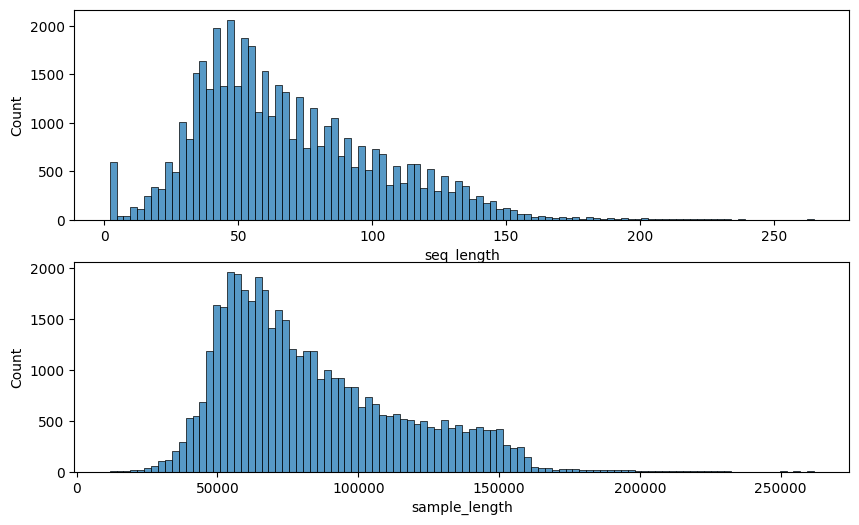

In [5]:
# fig, ax = plt.subplots(2,1,figsize=(10, 6))
# sns.histplot(x=data['seq_length'], ax=ax[0])
# sns.histplot(x=data['sample_length'], ax=ax[1])
# plt.show()

## Split audios

In [6]:
def get_vocab(data):
    phonemes = []
    for sentence in data['phonemes']:
        for phoneme in sentence:
            phonemes.append(phoneme)

    vowels = ['a', 'e', 'i', 'o', 'u']
    markers = [' ', '<pad>', '<unk>', '<s>', '</s>']
    vocab = markers[1:] + [phoneme for (phoneme, _) in list(Counter(phonemes).most_common())]
    vocab = {phoneme: i for (i, phoneme) in enumerate(vocab)}
    consonants = [phoneme for phoneme in vocab if 
        phoneme not in (vowels + markers)]

    with open("Datasets/ASR-dataset/vocab.json", "w") as f:
        json.dump(vocab, f, indent=4)

    print("Number of phonemes:", len(vocab))
    print("Max sequence length:", data['seq_length'].max())
    print("Vowels:\n", vowels)
    print("Markers:\n", markers)
    print("Consonants:\n", consonants)

# get_vocab(data)

Number of phonemes: 40
Max sequence length: 265
Vowels:
 ['a', 'e', 'i', 'o', 'u']
Markers:
 [' ', '<pad>', '<unk>', '<s>', '</s>']
Consonants:
 ['n', 'k', 't', 'r', 'm', 's', 'sh', 'd', 'g', 'w', 'y', 'b', 'h', 'ts', 'j', 'ch', 'z', 'p', 'f', 'ky', 'ry', 'gy', 'hy', 'ny', 'by', 'my', 'py', 'v', 'dy', 'cl']


# Data Loaders

## Tensorflow TFRecord loader

In [7]:
class TFRWriter:
    def __init__(self, args):
        self.args = args
        self.data = pd.read_csv(f"{args.main_dir}\ASRDataset_cleaned.csv")
        self.tokenizer = Wav2Vec2CTCTokenizer(
            f"{args.main_dir}/vocab.json",
            bos_token="<s>",
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>",
            word_delimiter_token=' ')
        self.feature_extractor = Wav2Vec2FeatureExtractor(
            sampling_rate=args.sample_rate,
            do_normalize=True,
            return_attention_mask=True)

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'audio_mask': self._bytes_feature(args[1]),
            'label': self._bytes_feature(args[2])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def tokenize_labels(self, text):
        tokens = self.tokenizer.tokenize(text)
        tokens = ['<s>'] + tokens + ['</s>']
        tokens += ['<pad>'] * (self.args.max_len - len(tokens))
        label = self.tokenizer.convert_tokens_to_ids(tokens)[:self.args.max_len]
        return tf.convert_to_tensor(label, dtype=tf.int8)

    def get_shards(self, data):
        skf = StratifiedKFold(
            n_splits=self.args.n_shards, shuffle=True, random_state=42)
        splits = [val_idx for _, val_idx in skf.split(data['path'], data['corpus'])]
        return splits

    def get_audio(self, path):
        audio = librosa.load(path, sr=self.args.sample_rate)[0]
        outputs = self.feature_extractor(
            audio, padding="max_length", max_length=self.args.max_samples,
            sampling_rate=self.args.sample_rate, truncation=True, 
            return_tensors='tf')
        input_values = tf.squeeze(outputs.input_values, axis=0)[:self.args.max_samples]
        attention_mask = tf.squeeze(outputs.attention_mask, axis=0)[:self.args.max_samples]
        attention_mask = tf.cast(attention_mask, dtype=tf.int8)
        return input_values, attention_mask

    def generator(self, samples):
        for sample_idx in samples:
            label = self.tokenize_labels(self.data['romaji'][sample_idx])
            path = os.path.join(
                self.args.main_dir, "wav_cleaned", self.data['path'][sample_idx])
            audio, audio_mask = self.get_audio(path)
            yield {
                "audio": tf.io.serialize_tensor(audio),
                "audio_mask": tf.io.serialize_tensor(audio_mask),
                "label": tf.io.serialize_tensor(label)}

    def write(self):
        for shard, sample_ids in tqdm(
                enumerate(self.get_shards(self.data)), 
                total=self.args.n_shards):
            with tf.io.TFRecordWriter(
                    f"{self.args.main_dir}/tfrec/shard_{shard+1}.tfrec") as f:
                for sample in self.generator(sample_ids):
                    example = self.serialize_example(
                        sample['audio'], sample['audio_mask'],
                        sample['label'])
                    f.write(example)

# TFRWriter(args).write()

In [8]:
class TFDataLoader:
    def __init__(self, args):
        self.files = glob.glob(args.main_dir + "/tfrec/*.tfrec")
        self.args = args
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True)
        self.train = self.train()
        self.val = self.val()

    def decode_audio(self, audio):
        audio = tf.audio.decode_wav(
            audio, 
            desired_channels=1,
            desired_samples=self.args.max_samples)[0]
        return tf.squeeze(audio, axis=-1)           

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'audio_mask': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = tf.io.parse_tensor(
            example['audio'], out_type=tf.float32)
        example['audio_mask'] = tf.io.parse_tensor(
            example['audio_mask'], out_type=tf.int8)
        example['label'] = tf.io.parse_tensor(
            example['label'], out_type=tf.int8)   

        inputs = {
            'audio': example['audio'], 
            'audio_mask': example['audio_mask']}
        outputs = {'label': example['label']}
        return inputs, outputs

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return tfds.as_numpy(dataset)

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return tfds.as_numpy(dataset)

# train = DataLoader(args).train
# val = DataLoader(args).val
# inputs, outputs = next(iter(val))
# print("audio shape:", inputs['audio'].shape)
# print("audio_mask shape:", inputs['audio_mask'].shape)
# print("label shape:", outputs['label'].shape)

## Pytorch Dataset/Dataloader

In [85]:
# Processor
tokenizer = Wav2Vec2CTCTokenizer(
    f"{args.main_dir}/vocab.json",
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    word_delimiter_token=' ')

feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=args.sample_rate,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True)

processor = Wav2Vec2Processor(
    feature_extractor=feature_extractor, 
    tokenizer=tokenizer)

In [122]:
data = pd.read_csv(os.path.join(args.main_dir, "ASRDataset_cleaned.csv"))
stratifier = data['corpus']
data = data[['path', 'romaji']]

train, val = train_test_split(data, test_size=0.2, stratify=stratifier)

In [137]:
class ASRDataset(Dataset):
    def __init__(self, args, data):
        self.args = args
        self.data = data.reset_index(drop=True)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        wav_path = os.path.join(
            self.args.main_dir, "wav_cleaned", self.data.loc[idx, "path"])

        audio = torchaudio.load(wav_path, channels_first=False)[0]
        labels = self.data.loc[idx, "romaji"]
        labels = self.tokenizer(labels, return_tensors='pt')['input_ids']
        return audio, labels

train_dataset = ASRDataset(args, train)
val_dataset = ASRDataset(args, val)
next(iter(val_dataset))

(tensor([[ 9.1553e-05],
         [-3.0518e-05],
         [ 3.0518e-05],
         ...,
         [ 3.0518e-05],
         [ 0.0000e+00],
         [ 3.0518e-05]]),
 tensor([[11, 10, 13, 10, 17,  6,  4, 14,  6,  4, 15,  6, 13, 10,  4, 18,  5,  4,
          14,  8, 11,  5,  8,  4, 10, 23,  8,  8, 24,  7,  4, 12,  5,  4, 11,  5,
          23,  8,  8, 24,  7,  4,  9,  5,  7,  4, 11,  5,  4, 19,  5, 11,  5, 13,
           5,  4,  9,  5,  7,  4,  8, 25,  7,  4,  9,  7,  4, 11,  5,  9,  6, 24,
           6,  4,  9,  6,  4, 11,  8, 13,  8, 14,  5,  4, 19,  5,  4, 14,  6,  8,
           4, 17, 10,  9, 16,  5,  4, 12,  6,  8, 13,  7,  4,  6,  4, 20,  6, 11,
           6,  4,  9,  7,  4, 11,  7, 13, 10,  4, 12, 10,  4,  7,  4, 12,  5]]))

In [111]:
def collate_fn(batch):
    return tuple(zip(*batch))



dataloader = DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)


j = 0
for i in dataloader:
    print(i)
    if j == 5:
        break
    j += 1

((tensor([[-2.4414e-04],
        [-2.7466e-04],
        [-3.0518e-04],
        ...,
        [-1.8311e-04],
        [-1.2207e-04],
        [-3.0518e-05]]), tensor([[0.0002],
        [0.0003],
        [0.0002],
        ...,
        [0.0002],
        [0.0006],
        [0.0008]]), tensor([[0.0020],
        [0.0023],
        [0.0025],
        ...,
        [0.0021],
        [0.0021],
        [0.0022]]), tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])), (tensor([[12.,  6., 23.,  8., 26., 10.,  9.,  4., 28.,  8., 15.,  8., 14.,  5.,
          4., 18.,  5.,  4.,  5.,  7.,  4., 12.,  5.,  4.,  9., 10., 18.,  5.,
         10., 13.,  7.,  4.,  6.,  4.,  8., 12., 12., 10.,  4.,  7., 13.,  7.,
         18.,  8., 25.,  7.,  4.,  6.,  4., 14.,  7., 13.,  8.,  4., 12.,  6.]]), tensor([[22.,  7., 15.,  5.,  7., 25.,  7.,  4., 15.,  5.,  9.,  4.,  9.,  6.,
          4., 11.,  5.,  6.,  4., 18.,  5., 25.,  7.,  7., 15.,  5., 11.,  8.,
          4.,  9.,  5